# Hate Speech Dataset

In [1]:
import sys
sys.path.append('../')
import torch
import numpy as np
import utils

In [2]:
from model import Model
from dataset_class import HateSpeechDataset
from evaluation import EvaluationClassification
import estimators
import acquisition
import metrics
import visualize
import ase

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
prompt_respond = """Does the sentence contain hate speech? Respond with "yes" or "no".\n"""

In [4]:
dataset_file = 'hatespeech'

## LLaMa2 70B

In [6]:
model_file = 'llama2_70b'

In [ ]:
llama = Model(model_name="Llama-2-70b",
                    model_file=model_file,
                    dataset_file=dataset_file,
                    prompt=prompt_respond,
                    device=device)

In [8]:
hatespeech_dataset = HateSpeechDataset(dataset_file=dataset_file)
hatespeech_dataset.load(prompt=llama.prompt,
                        tokenizer=llama.model.tokenizer, 
                        device=device)

In [9]:
llama_evaluation = EvaluationClassification(llama,
                                            hatespeech_dataset,
                                            device)

In [11]:
llama_evaluation.evaluation_procedure("active", batch_size=5, save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:01:40<00:00,  1.85s/it]

Accuracy: 0.8396000266075134 - Loss: 0.538923978805542


In [ ]:
llama_evaluation.evaluation_icl_procedure("active", nb_icl_examples=50, batch_size=1, save=True, version=1)

## LLaMa2 7B

In [ ]:
model_file = 'llama2_7b'

In [ ]:
llama = Model(model_name="Llama-2-7b-8bit",
                    model_file=model_file,
                    dataset_file=dataset_file,
                    prompt=prompt_respond,
                    device=device)

In [ ]:
hatespeech_dataset = HateSpeechDataset(dataset_file='hatespeech')
hatespeech_dataset.load(prompt=llama.prompt,
                        tokenizer=llama.model.tokenizer, 
                        device=device)

In [8]:
llama_evaluation = EvaluationClassification(llama,
                                            hatespeech_dataset,
                                            device)

In [ ]:
llama_evaluation.evaluation_procedure('active', batch_size=5, save=True)

In [10]:
llama_evaluation.evaluation_icl_procedure('active', nb_icl_examples=50, batch_size=5, save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:12:12<00:00,  2.17s/it]

Accuracy: 0.890999972820282 - Loss: 0.28131020069122314


## Acquisition

In [5]:
STEP = 1
RUNS = 3_000
SIZE = 400

### LURE-based Active Testing

In [7]:
llama_acquisition = acquisition.SurrogateEntropyAcquisition(step=STEP,
                                                            runs=RUNS,
                                                            size=SIZE,
                                                            eps=1e-15,
                                                            model_file='llama2_70b_icl50',
                                                            surrogate_file="llama2_7b_icl50",
                                                            dataset_file=dataset_file,
                                                            loss=metrics.cross_entropy_loss,
                                                            temperature=None)
llama_acquisition.run_estimation(coverage_probability=0.1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:09<00:00,  6.99it/s]


In [ ]:
phi_acquisition = acquisition.SurrogateEntropyAcquisition(step=STEP,
                                                            runs=RUNS,
                                                            size=SIZE,
                                                            eps=1e-15,
                                                            model_file='llama2_70b_icl50',
                                                            surrogate_file='llama2_7b_icl50',
                                                            dataset_file=dataset_file,
                                                            loss=metrics.cross_entropy_loss,
                                                            temperature=None)
phi_acquisition.get_coverage_estimation(n_runs=100)

### Active testing with no weight (naive)

In [ ]:
llama_acquisition = acquisition.SurrogateEntropyAcquisition(step=STEP,
                                                            runs=RUNS,
                                                            size=SIZE,
                                                            eps=1e-15,
                                                            model_file='llama2_70b_icl50',
                                                            surrogate_file="llama2_7b_icl50",
                                                            dataset_file=dataset_file,
                                                            loss=metrics.cross_entropy_loss,
                                                            estimator=estimators.iidEstimator,
                                                            temperature=None)
llama_acquisition.run_estimation(coverage_probability=0.1)

### I.I.D.

In [9]:
phi_acquisition = acquisition.iidAcquisition(step=STEP,
                                            runs=RUNS,
                                            size=SIZE,
                                            eps=1e-15,
                                            model_file="llama2_70b_icl50",
                                            dataset_file=dataset_file,
                                            loss=metrics.cross_entropy_loss)
phi_acquisition.run_estimation()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [09:30<00:00,  5.26it/s]


### ASE

In [14]:
ase_estimator = ase.ActiveSurrogateEstimator(model_file="llama2_70b_icl50",
                                            surrogate_file="llama2_7b_icl50",
                                            dataset_file='hatespeech',
                                            loss=metrics.cross_entropy_loss)
ase_estimator.zero_shot_estimate()

## Figures

In [6]:
visualize.setup_matplotlib()

In [7]:
true_error = utils.load_tensors(f'hatespeech/llama2_70b_icl50/full_set_loss').numpy()

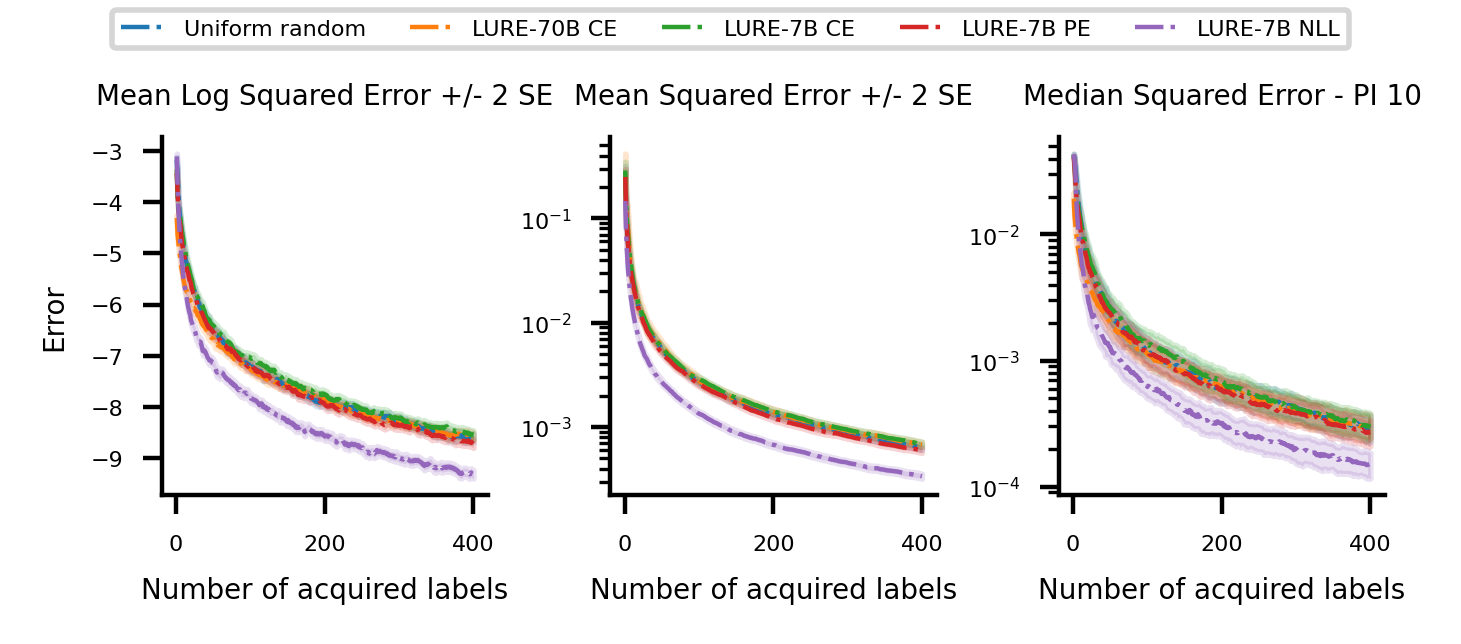

In [8]:
res_dict = {
    'Uniform random': utils.load_arrays('hatespeech/llama2_70b_icl50/llama2_70b_icl50_iid_loss'),
    'LURE-70B CE': utils.load_arrays('hatespeech/llama2_70b_icl50/llama2_70b_icl50_llama2_70b_icl50_loss'), 
    'LURE-7B CE': utils.load_arrays('hatespeech/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss'), 
    'LURE-7B PE': utils.load_arrays('hatespeech/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss_entropy'), 
    'LURE-7B NLL': utils.load_arrays('hatespeech/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss_nll'), 
}
visualize.plot_all_errors(res_dict, true_error, STEP, title='', savefig=(False, ''))